## Scraping Challenge

Do a little scraping or API-calling of your own.  Pick a new website and see what you can get out of it.  Expect that you'll run into bugs and blind alleys, and rely on your mentor to help you get through.  

Formally, your goal is to write a scraper that will:

1) Return specific pieces of information (rather than just downloading a whole page)  
2) Iterate over multiple pages/queries  
3) Save the data to your computer  

Once you have your data, compute some statistical summaries and/or visualizations that give you some new insights into your scraping topic of interest.  Write up a report from scraping code to summary and share it with your mentor.

### Craigslist Hot Tubs For Sale
I will scrape all of the hot tubs for sale in the Denver area to analyze sale prices.

In [1]:
# Importing in each cell because of the kernel restarts.
import scrapy
from scrapy.crawler import CrawlerProcess


class CLSpider(scrapy.Spider):
    # Naming the spider is important if you are running more than one spider of
    # this class simultaneously.
    name = "CL"
    
    # URL(s) to start with.
    start_urls = [
        'https://denver.craigslist.org/search/sss?query=hot%20tub&sort=rel',
    ]

    # Use XPath to parse the response we get.
    def parse(self, response):
        
        # Iterate over every <article> element on the page.
        for posting in response.xpath('//p'):
            
            # Yield a dictionary with the values we want.
            yield {
                # This is the code to choose what we want to extract
                # You can modify this with other Xpath expressions to extract other information from the site
                'title': posting.xpath('a[@class="result-title hdrlnk"]/text()').extract_first(),
                'date': posting.xpath('time[@class="result-date"]/text()').extract_first(),
                'price': posting.xpath('span/span[@class="result-price"]/text()').extract_first()
            }
        next_page = response.xpath('//div/div/span[@class="buttons"]/a[3][@href]').extract_first()
        
        pagenum = int(re.findall(r'\d+',next_page)[0])
        
        if next_page is not None and pagenum < 10:
            next_page = response.urljoin(next_page)
            yield scrapy.Request(next_page, callback=self.parse)

# Tell the script how to run the crawler by passing in settings.
process = CrawlerProcess({
    'FEED_FORMAT': 'json',         # Store data in JSON format.
    'FEED_URI': 'cldata.json',  # Name our storage file.
    'ROBOTSTXT_OBEY': True,
    'USER_AGENT': 'ThinkfulDataScienceBootcamp_Katherine (thinkful.com)',
    'AUTOTHROTTLE_ENABLED': True,
    'HTTPCACHE_ENABLED': True,
    'LOG_ENABLED': False           # Turn off logging for now.
})

# Start the crawler with our spider.
process.crawl(CLSpider)
process.start()
print('Success!')


Success!


Now that the Spider scraped the data, let's create a data frame to display and analyze the data.

In [2]:
import pandas as pd

# Turning JSON into Data Frame
tubs = pd.read_json('cldata.json')
print(tubs.shape)
tubs.head()

(120, 3)


,date,price,title
0,Jun 7,$500,Hot tub
1,Jun 7,$350,Hot tub for Sale
2,Jun 7,None,Hot tub & Spa Cover Super sale
3,Jun 7,None,(A+) JUNK REMOVAL~ HOT TUB REMOVAL~CONCRETE -&...
4,Jun 7,$50,Sub panel hot tub ?


Great! This worked, but I can't seem to get the next pages to work.  I'll write these up for now.

Next step will be to clean out the dollar signs from the price and then turning the non-"None" values into integers.

In [3]:
import re

tubs.price = tubs.price.map(lambda x: None if x == None else int(re.sub('\$', '', str(x))))
tubs.head()

,date,price,title
0,Jun 7,500.0,Hot tub
1,Jun 7,350.0,Hot tub for Sale
2,Jun 7,NaN,Hot tub & Spa Cover Super sale
3,Jun 7,NaN,(A+) JUNK REMOVAL~ HOT TUB REMOVAL~CONCRETE -&...
4,Jun 7,50.0,Sub panel hot tub ?


Fantastic! Now, let's find the average price for a hot tub in the denver area.

In [4]:
tubwprice = tubs[tubs.price>0]
average_price = tubwprice.price.mean()
print(average_price)

1088.1904761904761


Looks like the average price for a hot tub is \$1088. 

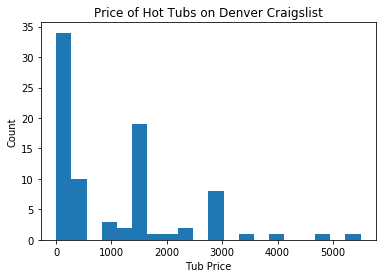

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(tubwprice.price, bins=20)
plt.xlabel('Tub Price')
plt.ylabel('Count')
plt.title('Price of Hot Tubs on Denver Craigslist')
plt.show()

Although the average price listed is \$1088, it appears that most hot tubs are listed for under \$500, with around 17 listed around \$1500 and some listed at a significantly higher price. 

## Failed Attempt
I really wanted to get the below Indeed Spider to work, but couldn't.  Thoughts?

In [1]:
# Importing in each cell because of the kernel restarts.
import scrapy
from scrapy.crawler import CrawlerProcess


class IndSpider(scrapy.Spider):
    # Naming the spider is important if you are running more than one spider of
    # this class simultaneously.
    name = "Ind"
    
    # URL(s) to start with.
    start_urls = [
        'https://www.indeed.com/jobs?q=data+scientist&l=Denver,+CO&explvl=entry_level',
    ]

    # Use XPath to parse the response we get.
    def parse(self, response):
        
        # Iterate over every <article> element on the page.
        for posting in response.xpath('//*div[contains(@class,"result")]'):
            
            # Yield a dictionary with the values we want.
            yield {
                # This is the code to choose what we want to extract
                # You can modify this with other Xpath expressions to extract other information from the site
                'job_title': posting.xpath('h2/a[@title]/text()').extract(),
                'company': posting.xpath('span[@class="company"]/a/text()').extract(),
                'summary': posting.xpath('table/tbody/tr/td/div/span/text()').extract()
            }

# Tell the script how to run the crawler by passing in settings.
process = CrawlerProcess({
    'FEED_FORMAT': 'json',         # Store data in JSON format.
    'FEED_URI': 'firstpageindeed.json',  # Name our storage file.
    'ROBOTSTXT_OBEY': True,
    'USER_AGENT': 'ThinkfulDataScienceBootcamp_Katherine (thinkful.com)',
    'AUTOTHROTTLE_ENABLED': True,
    'HTTPCACHE_ENABLED': True,
    'LOG_ENABLED': True           # Turn off logging for now.
})

# Start the crawler with our spider.
process.crawl(IndSpider)
process.start()
print('Success!')


2018-06-07 18:59:53 [scrapy.utils.log] INFO: Scrapy 1.5.0 started (bot: scrapybot)
2018-06-07 18:59:53 [scrapy.utils.log] INFO: Versions: lxml 4.2.1.0, libxml2 2.9.8, cssselect 1.0.3, parsel 1.4.0, w3lib 1.19.0, Twisted 18.4.0, Python 3.6.2 (v3.6.2:5fd33b5926, Jul 16 2017, 20:11:06) - [GCC 4.2.1 (Apple Inc. build 5666) (dot 3)], pyOpenSSL 18.0.0 (OpenSSL 1.1.0h  27 Mar 2018), cryptography 2.2.2, Platform Darwin-17.5.0-x86_64-i386-64bit
2018-06-07 18:59:53 [scrapy.crawler] INFO: Overridden settings: {'AUTOTHROTTLE_ENABLED': True, 'FEED_FORMAT': 'json', 'FEED_URI': 'firstpageindeed.json', 'HTTPCACHE_ENABLED': True, 'ROBOTSTXT_OBEY': True, 'USER_AGENT': 'ThinkfulDataScienceBootcamp_Katherine (thinkful.com)'}
2018-06-07 18:59:53 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.memusage.MemoryUsage',
 'scrapy.extensions.feedexport.FeedExporter',
 'scrapy.extensions.logstats.LogStats',
 'scr

Success!


This scraper keeps either exporting an empty file or it won't 